## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # root package
import torch.nn as nn                             # neural networks
import torch.optim as optim                       # optimizers e.g. gradient descent, ADAM, etc.

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device')

Using cuda device


# 02

## Decision boundary function

In [4]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Hyperparameters

In [31]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
TRAIN_SIZE = 0.2
HIDDEN_UNITS = 8
RATE = 0.1
EPOCHS = 200

## Data

In [32]:
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(device)

X_train,X_test,y_train,y_test = train_test_split(X_blob,
                                                 y_blob,
                                                 train_size=TRAIN_SIZE,
                                                 random_state=RANDOM_SEED)

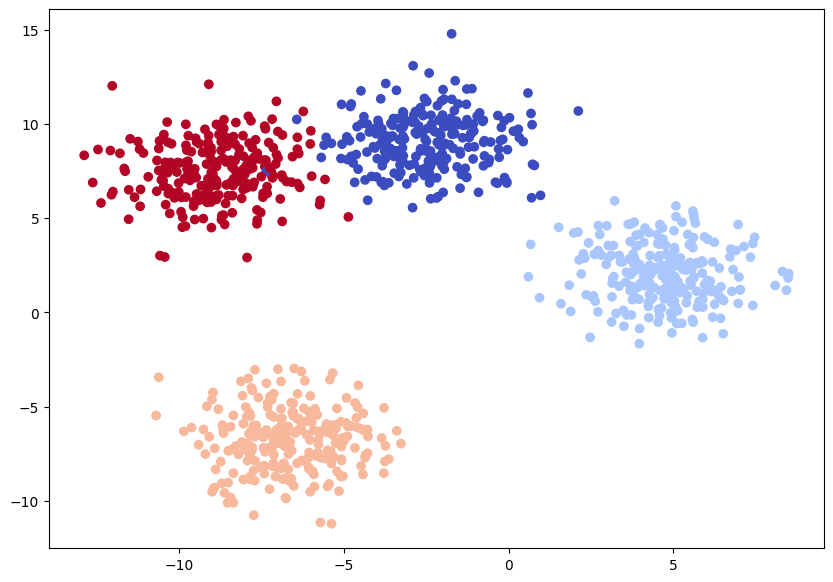

In [33]:
plt.figure(figsize=(10,7))
X_blob_cpu = X_blob.cpu()
plt.scatter(X_blob_cpu[:,0],
            X_blob_cpu[:,1],
            c=y_blob.cpu(),
            cmap='coolwarm')

## Model

In [34]:
activation = nn.ReLU()

class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features=hidden_units),
            activation,
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            activation,
            nn.Linear(in_features=hidden_units,
                      out_features=output_features)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

torch.manual_seed(RANDOM_SEED)    
model_2 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=HIDDEN_UNITS).to(device)

In [35]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(params=model_2.parameters(),
                      lr=RATE)

### A very important thing to note is that here the loss function takes target as categorical indices while the predictions are to be presented as logits.

## Training

Final training loss: 0.0180
Final testing loss: 0.0298


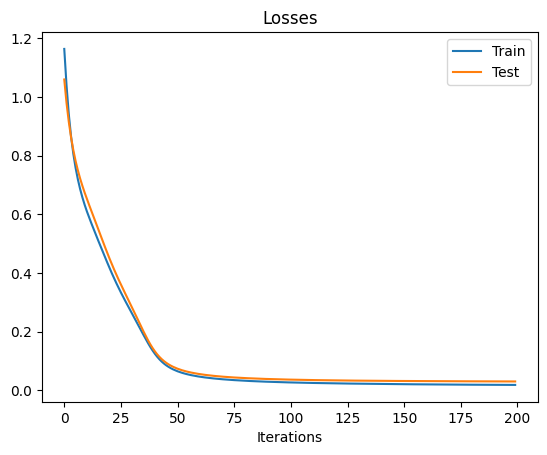

In [36]:
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    model_2.train()
    y_train_logits = model_2(X_train)
    y_train_pred = torch.softmax(y_train_logits,dim=1).argmax(dim=1)
    loss_train = loss_fn(y_train_logits,y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        y_test_logits = model_2(X_test)
        y_test_preds = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
        loss_test = loss_fn(y_test_logits,y_test)

    train_losses[epoch] = float(eval(f"{loss_train:.5f}"))
    test_losses[epoch] = float(eval(f"{loss_test:.5f}"))

print(f"Final training loss: {loss_train:.4f}")
print(f"Final testing loss: {loss_test:.4f}")

plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.legend()
plt.title("Losses")
plt.xlabel("Iterations")
plt.show()

## Decision boundaries

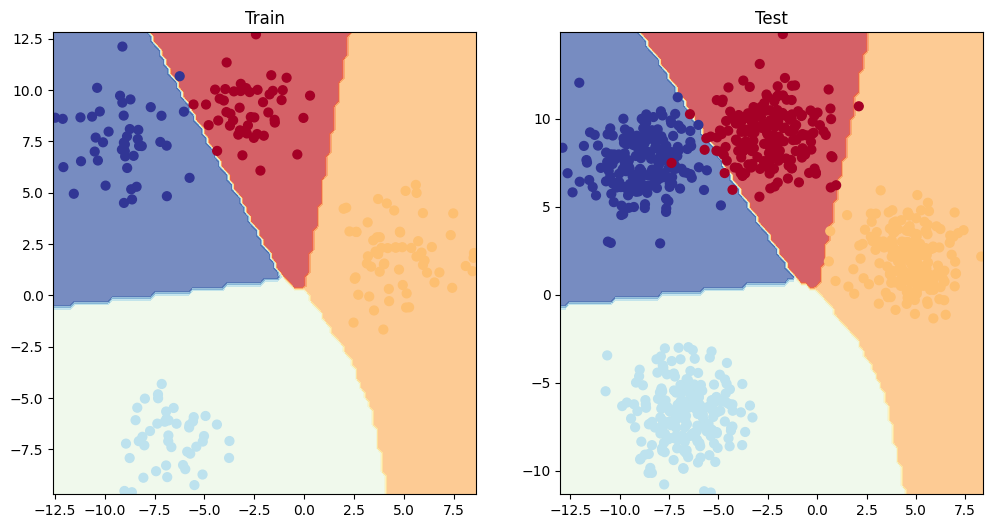

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)
plt.show()